## Запуск предсказаний Boltz

### v1 — стандартный запуск
```bash
boltz predict data/processed/cache2/yamls
```

### v2 — ускоренный запуск
```bash
boltz predict data/processed/cache2/yamls \
  --recycling_steps 1 \
  --sampling_steps 2 \
  --sampling_steps_affinity 2 \
  --diffusion_samples_affinity 1
```

In [1]:
import pandas as pd 

df_ki = pd.read_csv('../data/processed/cache2/summary.tsv', sep='\t')
print(f"Row number: {df_ki.shape[0]}")
print(f"Mean of target column: {df_ki["target"].mean():.3f}")
print()

df_aff = pd.read_csv('../results/boltz_results_cache2_v1_affinity_summary.tsv', sep='\t') 
df_v1 = df_ki.merge(df_aff, on='id')

df_aff = pd.read_csv('../results/boltz_results_cache2_v2_affinity_summary.tsv', sep='\t') 
df_v2 = df_ki.merge(df_aff, on='id')

print(f"v1 row number: {df_v1.shape[0]}")
print(f"Mean of target column: {df_v1["target"].mean():.3f}")
print()

print(f"v2 row number: {df_v2.shape[0]}")
print(f"Mean of target column: {df_v2["target"].mean():.3f}")

Row number: 1957
Mean of target column: 0.181

v1 row number: 1925
Mean of target column: 0.183

v2 row number: 1925
Mean of target column: 0.183


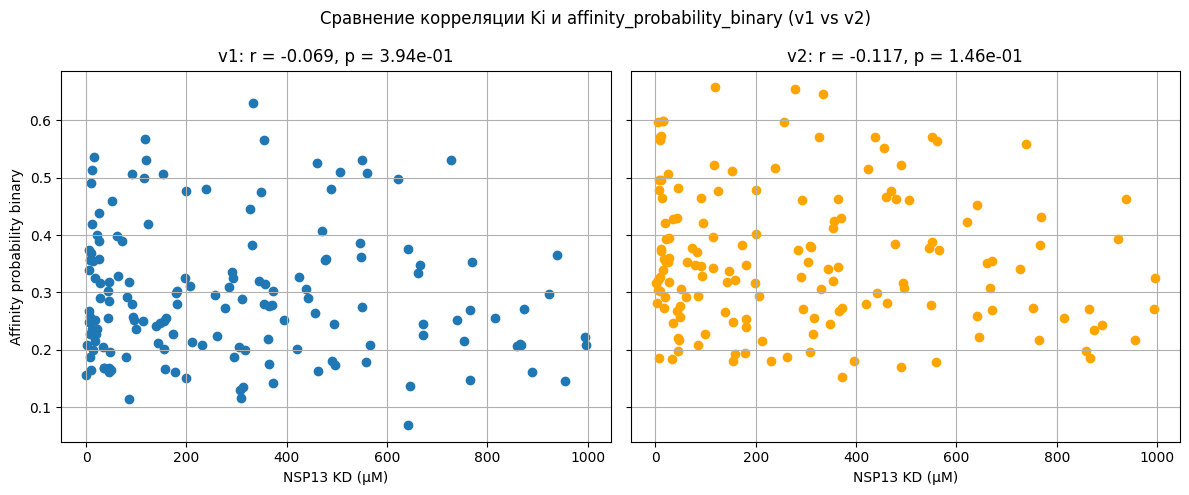

In [2]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

def clean_numeric(series):
    return pd.to_numeric(series, errors="coerce")

# добавляем числовой Ki
df_v1["NSP13_num"] = clean_numeric(df_v1["NSP13 KD (µM)"])
df_v2["NSP13_num"] = clean_numeric(df_v2["NSP13 KD (µM)"])

# убираем NaN
df_v1_num = df_v1.dropna(subset=["NSP13_num"])
df_v2_num = df_v2.dropna(subset=["NSP13_num"])

df_v1_num = df_v1_num[df_v1_num["NSP13_num"]>0]
df_v2_num = df_v2_num[df_v2_num["NSP13_num"]>0]

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# v1
r1, p1 = pearsonr(df_v1_num["NSP13_num"], df_v1_num["affinity_probability_binary"])
axes[0].scatter(df_v1_num["NSP13_num"], df_v1_num["affinity_probability_binary"])
axes[0].set_xlabel("NSP13 KD (µM)")
axes[0].set_ylabel("Affinity probability binary")
axes[0].set_title(f"v1: r = {r1:.3f}, p = {p1:.2e}")
axes[0].grid(True)

# v2
r2, p2 = pearsonr(df_v2_num["NSP13_num"], df_v2_num["affinity_probability_binary"])
axes[1].scatter(df_v2_num["NSP13_num"], df_v2_num["affinity_probability_binary"], color="orange")
axes[1].set_xlabel("NSP13 KD (µM)")
axes[1].set_title(f"v2: r = {r2:.3f}, p = {p2:.2e}")
axes[1].grid(True)

plt.suptitle("Сравнение корреляции Ki и affinity_probability_binary (v1 vs v2)")
plt.tight_layout()
plt.show()


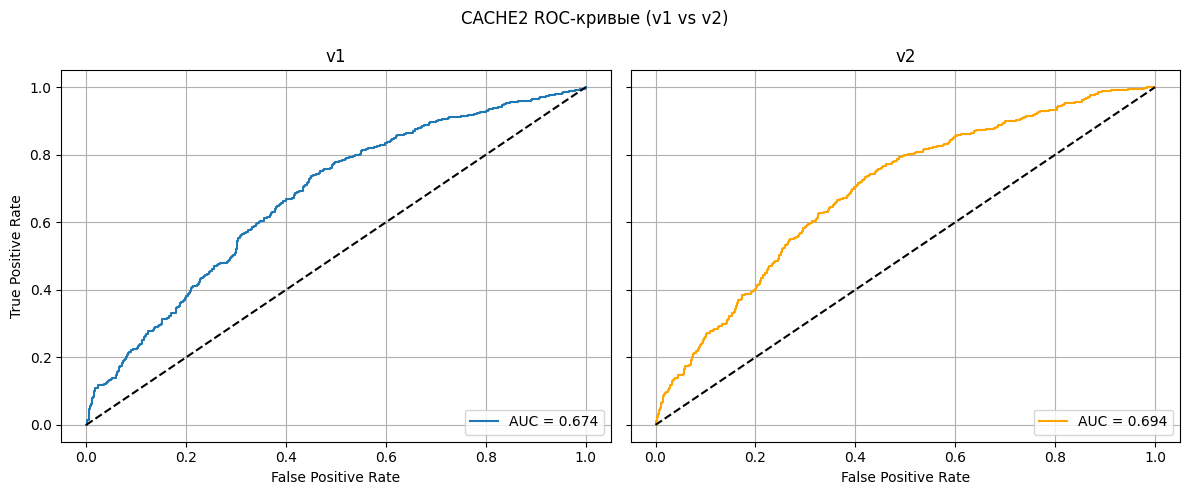

In [3]:
from sklearn.metrics import roc_auc_score, roc_curve

def plot_roc(df1, df2, label, title):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

    # v1
    auc1 = roc_auc_score(df1["target"], df1[label])
    fpr1, tpr1, _ = roc_curve(df1["target"], df1[label])
    axes[0].plot(fpr1, tpr1, label=f"AUC = {auc1:.3f}")
    axes[0].plot([0, 1], [0, 1], "k--")
    axes[0].set_title("v1")
    axes[0].set_xlabel("False Positive Rate")
    axes[0].set_ylabel("True Positive Rate")
    axes[0].legend(loc="lower right")
    axes[0].grid(True)

    # v2
    auc2 = roc_auc_score(df2["target"], df2[label])
    fpr2, tpr2, _ = roc_curve(df2["target"], df2[label])
    axes[1].plot(fpr2, tpr2, label=f"AUC = {auc2:.3f}", color="orange")
    axes[1].plot([0, 1], [0, 1], "k--")
    axes[1].set_title("v2")
    axes[1].set_xlabel("False Positive Rate")
    axes[1].legend(loc="lower right")
    axes[1].grid(True)

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# вызов
plot_roc(df_v1.copy(), df_v2.copy(),
         label="affinity_probability_binary",
         title="CACHE2 ROC-кривые (v1 vs v2)")
